# Augmented Reality

In this lab you will use RANSAC homography estimation in order to identify a tracking target and place an overlay image on top of it.

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import imageio
import skimage
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, plot_matched_features, SIFT
import cv2

The "reference" image (`ref_img`) is the image I printed out and put on the table.  

The "video" image (`vid_img`) is a frame from the video I took of the table.  

The "overlay" image (`overlay`) is the image that we will overlay on top of the video image.

In [2]:
ref_img = imageio.imread('stones.png')[...,:3]
vid_img = imageio.imread('stones1.png')
overlay = imageio.imread('overlay.png')[...,:3]

/var/folders/q8/mqm68gfx7pjfpqftf7y_v6140000gn/T/ipykernel_13365/2543003956.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ref_img = imageio.imread('stones.png')[...,:3]
/var/folders/q8/mqm68gfx7pjfpqftf7y_v6140000gn/T/ipykernel_13365/2543003956.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  vid_img = imageio.imread('stones1.png')
/var/folders/q8/mqm68gfx7pjfpqftf7y_v6140000gn/T/ipykernel_13365/2543003956.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning 

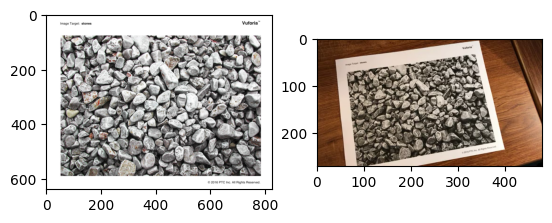

In [3]:
fig,axes = plt.subplots(1,2)
axes[0].imshow(ref_img)
axes[1].imshow(vid_img)


Let's compute and match SIFT descriptors between them.

In [4]:
descriptor_extractor = SIFT()

In [5]:
descriptor_extractor.detect_and_extract(rgb2gray(ref_img))
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

In [6]:
descriptor_extractor.detect_and_extract(rgb2gray(vid_img))
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

In [7]:
matches12 = match_descriptors(
    descriptors1, descriptors2, max_ratio=0.7, cross_check=True
)

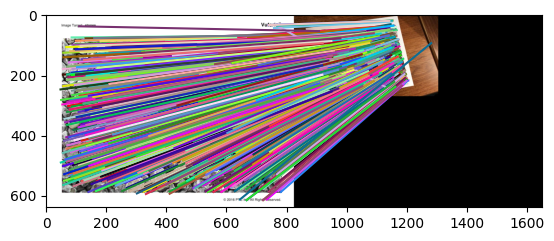

In [8]:
fig,ax = plt.subplots()
plot_matched_features(ref_img, vid_img, keypoints0=keypoints1, keypoints1=keypoints2, matches=matches12, ax=ax, only_matches=True)

# Exercises

1. Now use OpenCV's `findHomography` function to find a homography within the matches (using RANSAC).

Notes:
* OpenCV wants the points to have shape (N,1,2).  You will need to use `.reshape` to reshape the keypoint arrays.  They also need to be in `float32` data type.
* scikit-image has the keypoints as y,x but OpenCV wants x,y.
* Make sure to tell OpenCV to use RANSAC -- by default it simply computes the least squares homography estimate.

In [9]:
src = keypoints1[matches12[:, 0]]
dest = keypoints2[matches12[:, 1]]

srcCV = np.array([[p[1], p[0]] for p in src], dtype=np.float32).reshape(-1, 1, 2)
destCC = np.array([[p[1], p[0]] for p in dest], dtype=np.float32).reshape(-1, 1, 2)

H, mask = cv2.findHomography(
    srcCV, destCC, method=cv2.RANSAC, ransacReprojThreshold=5
)

print("Matrix H:", H)

Matrix H: [[ 4.00018744e-01  2.87924432e-02  3.92195162e+01]
 [-4.90587406e-02  3.48752127e-01  4.56512346e+01]
 [ 9.11261175e-05 -1.61465017e-04  1.00000000e+00]]


2. Show the inlier matches (using `plot_matched_features`) to check that it has found a good homography.

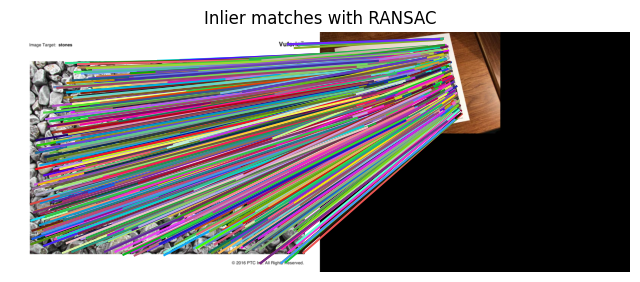

In [10]:
inlierMask = mask.ravel().astype(bool)
inlierMatches = matches12[inlierMask]

fig, ax = plt.subplots(figsize=(8, 6))
plot_matched_features(
    ref_img,
    vid_img,
    keypoints0=keypoints1,
    keypoints1=keypoints2,
    matches=inlierMatches,
    ax=ax,
    only_matches=True,
)
ax.set_title("Inlier matches with RANSAC")
ax.axis("off")
plt.show()

3. Now warp the overlay image using `cv2.warpPerspective` and provide it the homography you estimated.

Also warp a matrix of ones the same size as `overlay` (using `np.ones_like`) to make a mask indicating where the overlay should relace the video image.

Combine the images according to the mask and show the result.

In [11]:
h_vid, w_vid = vid_img.shape[:2]
warped_overlay = cv2.warpPerspective(
    overlay,
    H,
    dsize=(w_vid, h_vid),
)

In [12]:
mask = np.ones(overlay.shape[:2], dtype=np.uint8) * 255
warped_mask = cv2.warpPerspective(
    mask,
    H,
    dsize=(w_vid, h_vid),
)

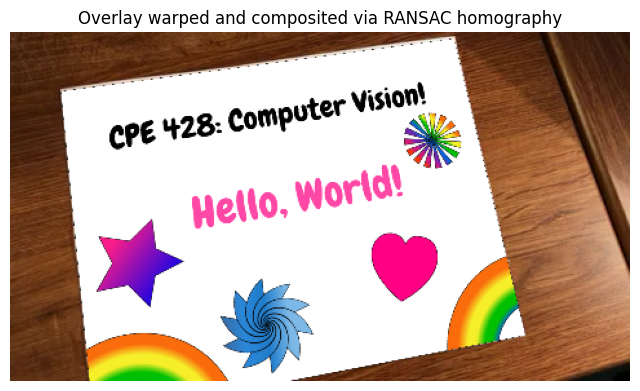

In [ ]:
mask_bool = warped_mask > 0

output = vid_img.copy()
output[mask_bool] = warped_overlay[mask_bool]

# 4. Display
plt.figure(figsize=(8,6))
plt.imshow(output)
plt.axis('off')
plt.title('Overlay warped and composited via RANSAC homography')
plt.show()